In [1]:
# Import necessary libraries
import os
import cv2
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from PIL import Image

In [2]:
# Define dataset paths
DATASET_PATH_1 = "C:/Users/ASUS/Downloads/KOA/MedicalExpert1/"  
DATASET_PATH_2 = "C:/Users/ASUS/Downloads/KOA/MedicalExpert2/" 

In [3]:
# Define image size
IMG_SIZE = 224

In [4]:
# Define KOA classification labels
KOA_CLASSES = {
    0: "Grade 0: Healthy",
    1: "Grade 1: Doubtful",
    2: "Grade 2: Minimal",
    3: "Grade 3: Moderate",
    4: "Grade 4: Severe"
}

In [5]:
# Function to load images from the dataset directory
def load_images(folder):
    images, labels = [], []
    for label in sorted(os.listdir(folder)):  # Loop through label directories
        label_path = os.path.join(folder, label)
        if os.path.isdir(label_path):  # Ensure it's a directory
            for filename in os.listdir(label_path):  # Loop through each image file
                img_path = os.path.join(label_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
                if img is not None:
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize image
                    images.append(img)
                    labels.append(int(label))  # Assign label
    return np.array(images), np.array(labels)

In [6]:
# Load and preprocess datasets from both sources
images1, labels1 = load_images(DATASET_PATH_1)
images2, labels2 = load_images(DATASET_PATH_2)


In [7]:
# Combine datasets
images = np.concatenate((images1, images2), axis=0)
labels = np.concatenate((labels1, labels2), axis=0)

In [8]:
# Normalize images to the range [0,1] and reshape for CNN input
images = images / 255.0
images = images.reshape(-1, IMG_SIZE, IMG_SIZE, 1)  # Adding channel dimension for grayscale images

In [9]:
# Convert labels to categorical format (one-hot encoding)
labels = to_categorical(labels, num_classes=5)

In [10]:
# Split dataset into training (80%), validation (10%), and testing (10%) sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [11]:
# Save preprocessed dataset for later use
np.savez("C:/Users/ASUS/Downloads/KOA/preprocesseddata_.npz",
         X_train=X_train, X_val=X_val, X_test=X_test, 
         y_train=y_train, y_val=y_val, y_test=y_test)

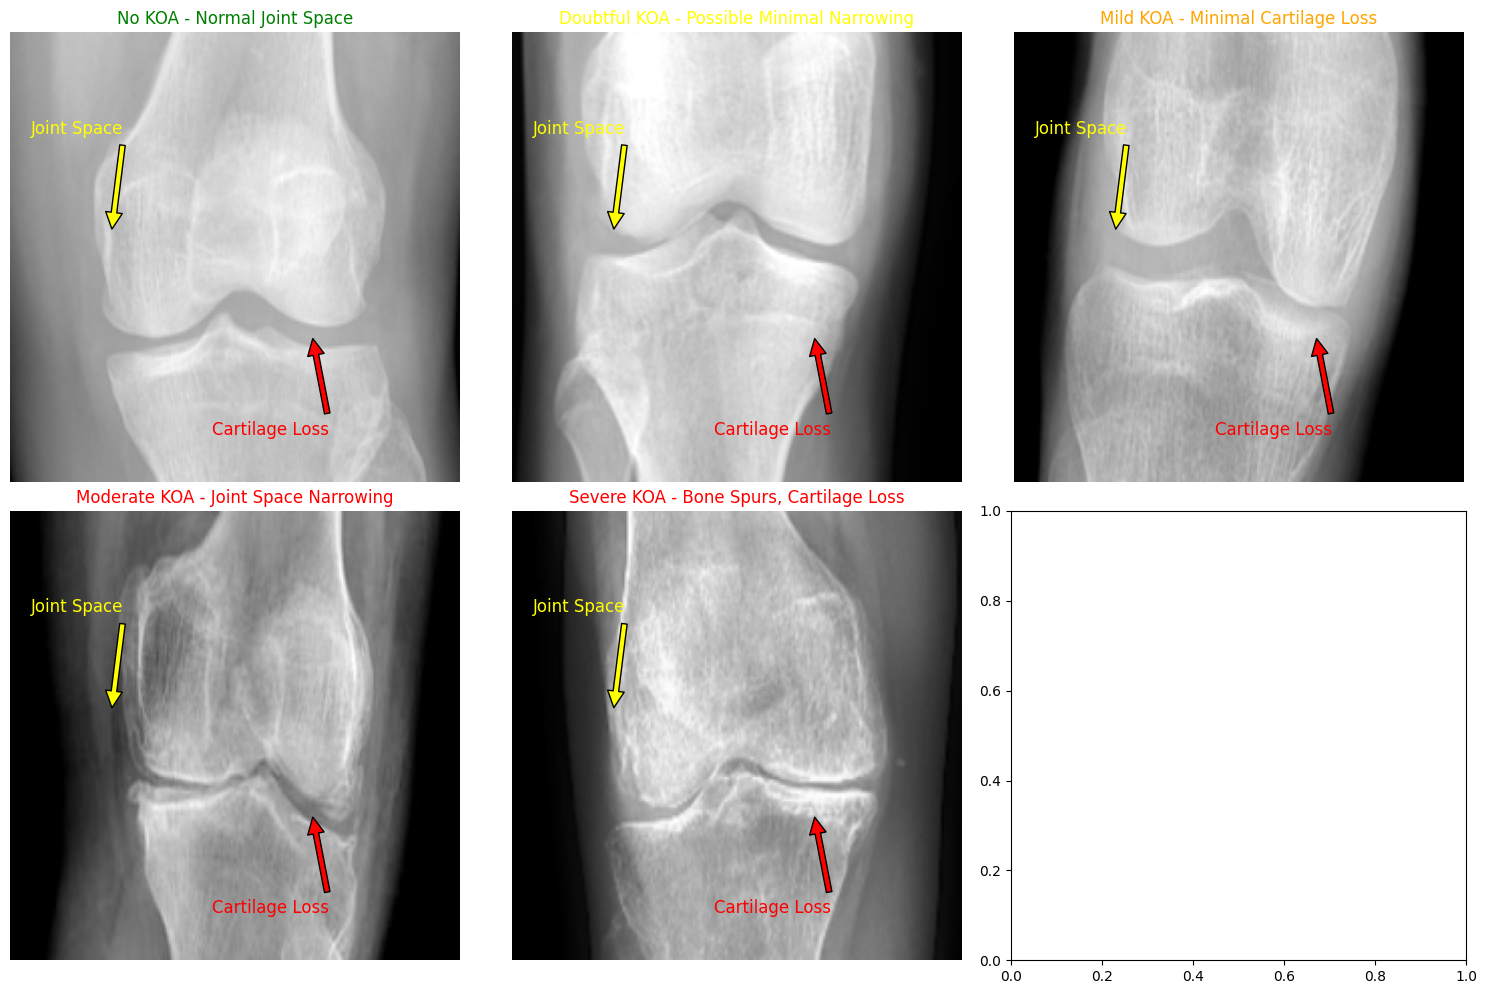

In [13]:
# Function to visualize images for each severity level with corresponding labels and arrows
def visualize_severity_images(images, labels):
    severity_levels = np.unique(labels)
    colors = {0: 'green', 1: 'yellow', 2: 'orange', 3: 'red', 4: 'red'}
    severity_names = {
        0: "No KOA - Normal Joint Space",
        1: "Doubtful KOA - Possible Minimal Narrowing",
        2: "Mild KOA - Minimal Cartilage Loss",
        3: "Moderate KOA - Joint Space Narrowing",
        4: "Severe KOA - Bone Spurs, Cartilage Loss"
    }
    
    fig, axes = plt.subplots(2, len(severity_levels) // 2 + 1, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, level in enumerate(severity_levels):
        idxs = np.where(labels == level)[0][:1]  # Get one occurrence per severity level
        for idx in idxs:
            img = images[idx].reshape(IMG_SIZE, IMG_SIZE)
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f'{severity_names[level]}', color=colors[level], fontsize=12)
            axes[i].axis('off')
            
            # Annotate key features
            axes[i].annotate('Joint Space', xy=(50, 100), xytext=(10, 50),
                             arrowprops=dict(facecolor='yellow', shrink=0.05), fontsize=12, color='yellow')
            axes[i].annotate('Cartilage Loss', xy=(150, 150), xytext=(100, 200),
                             arrowprops=dict(facecolor='red', shrink=0.05), fontsize=12, color='red')
    plt.tight_layout()
    plt.show()

# Visualize severity images
visualize_severity_images(images, np.argmax(labels, axis=1))

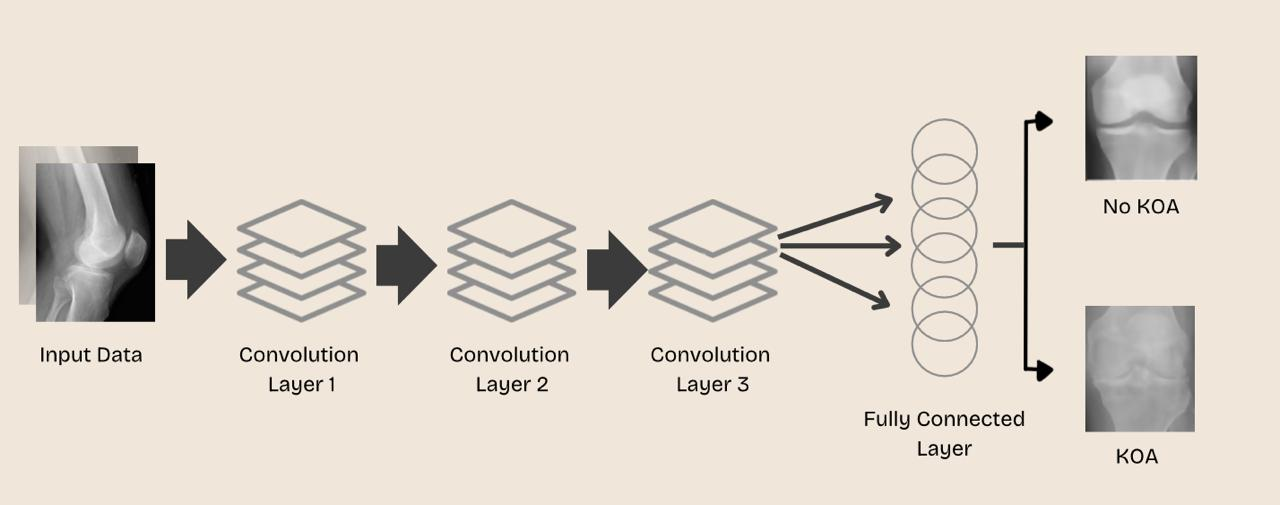

In [14]:
from IPython.display import Image
PATH = "C:/Users/ASUS/Downloads/"
Image(filename = PATH + "12layer_CNN.jpeg", width=1900, height=100)

In [15]:
# Function to define the CNN model
def build_cnn():
    model = Sequential([
        # Convolutional Layer 1
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
        MaxPooling2D((2,2)),

        # Convolutional Layer 2
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),

        # Convolutional Layer 3
        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),

        #fullly connected layer 
        Conv2D(256, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),

        # Dropout to prevent overfitting
        Dropout(0.5),

        # Flatten layer to convert 2D feature maps to 1D
        Flatten(),
        Dense(512, activation='relu'),
        
        # Dropout layer
        Dropout(0.5),

        # Output layer with softmax activation for multi-class classification
        Dense(5, activation='softmax')
    ])
    
    # Compile model with Adam optimizer and categorical crossentropy loss
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [16]:
# Train the CNN model
cnn_model = build_cnn()
history = cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, batch_size=32)

C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.2898 - loss: 1.5450 - val_accuracy: 0.3333 - val_loss: 1.5255
Epoch 2/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.3420 - loss: 1.4861 - val_accuracy: 0.3447 - val_loss: 1.4787
Epoch 3/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.3895 - loss: 1.4191 - val_accuracy: 0.3561 - val_loss: 1.3916
Epoch 4/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.4320 - loss: 1.3382 - val_accuracy: 0.3902 - val_loss: 1.3391
Epoch 5/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.4525 - loss: 1.2925 - val_accuracy: 0.4356 - val_loss: 1.2819
Epoch 6/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.4736 - loss: 1.2400 - val_accuracy: 0.4432 - val_loss: 1.2606
Epoch 7/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.5126 - loss: 1.1720 - val_accuracy: 0.4962 - val_loss: 1.1901
Epoch 8/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.5368 - loss: 1.1385 - val_accuracy: 0.5000 - v

In [17]:
# Save the trained model
cnn_model.save("C:/Users/ASUS/Downloads/KOA/cnn_model.h5")

In [19]:
# Load test data and trained model for evaluation
data = np.load("C:/Users/ASUS/Downloads/KOA/preprocesseddata_.npz")
X_test, y_test = data["X_test"], data["y_test"]
model = tf.keras.models.load_model("C:/Users/ASUS/Downloads/KOA/cnn_model.h5")

In [20]:
# Generate model predictions
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 391ms/step 


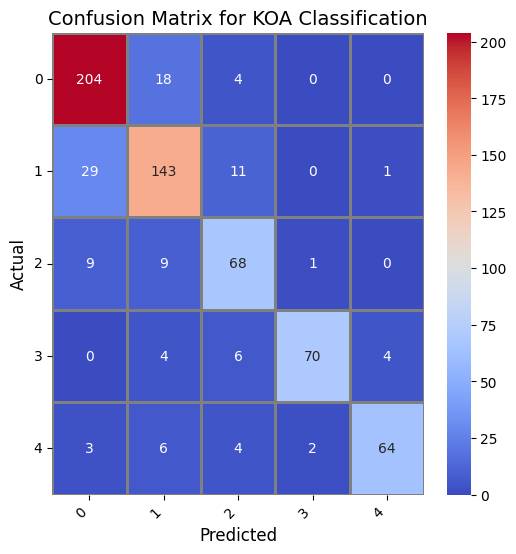

In [21]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=range(5), 
            yticklabels=range(5), linewidths=1, linecolor="gray")

# Set labels and title
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix for KOA Classification", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

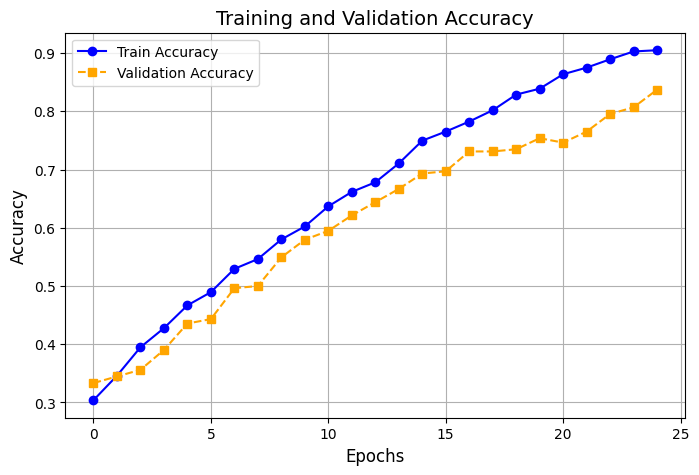

In [22]:
# Accuracy Plot
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label="Train Accuracy", marker="o", linestyle="-", color="blue")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy", marker="s", linestyle="--", color="orange")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=14)
plt.legend()
plt.grid()
plt.show()

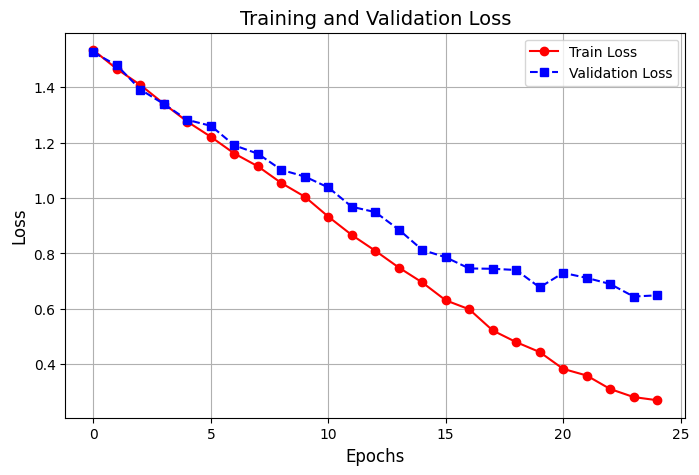

In [25]:
# Loss Curve
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label="Train Loss", marker="o", linestyle="-", color="red")
plt.plot(history.history['val_loss'], label="Validation Loss", marker="s", linestyle="--", color="blue")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Loss", fontsize=14)
plt.legend()
plt.grid()
plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 384ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 416ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 439ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 452ms/step


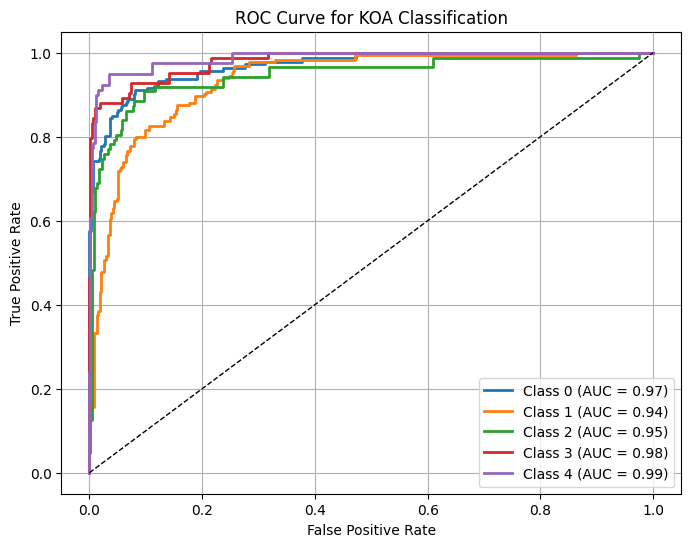

In [26]:
# ROC Curve
from sklearn.metrics import roc_curve, auc
n_classes = 5
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], model.predict(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})", lw=2)
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for KOA Classification")
plt.legend(loc="lower right")
plt.grid()
plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 366ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 399ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 499ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 471ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 399ms/step


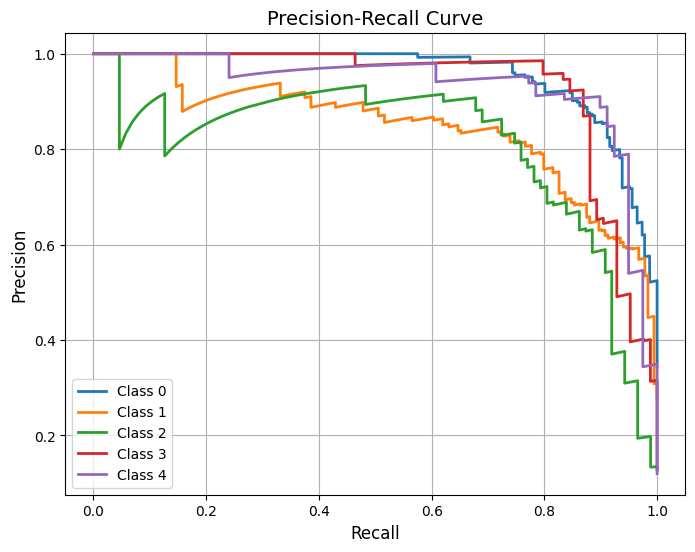

In [28]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve
plt.figure(figsize=(8, 6))
for i in range(5):
    precision, recall, _ = precision_recall_curve(y_test[:, i], model.predict(X_test)[:, i])
    plt.plot(recall, precision, label=f"Class {i}", lw=2)

plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision-Recall Curve", fontsize=14)
plt.legend(loc="lower left")
plt.grid()
plt.show()

In [29]:
# ---- Classification Report ----
print(classification_report(y_true, y_pred, target_names=KOA_CLASSES.values()))

                   precision    recall  f1-score   support

 Grade 0: Healthy       0.83      0.90      0.87       226
Grade 1: Doubtful       0.79      0.78      0.79       184
 Grade 2: Minimal       0.73      0.78      0.76        87
Grade 3: Moderate       0.96      0.83      0.89        84
  Grade 4: Severe       0.93      0.81      0.86        79

         accuracy                           0.83       660
        macro avg       0.85      0.82      0.83       660
     weighted avg       0.84      0.83      0.83       660

